### Capstone Project - The Battle of Neighborhoods


### The Required Packages

In [2]:
### Download and load all the dependencies

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import json # library to handle JSON files
import xml # to process XML


# !pip install geocoder  # uncomment this line if you haven't installed geocoder
import geocoder


# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


### Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


%matplotlib inline


### Import warnings
import warnings
warnings.filterwarnings('ignore')


### Import k-means from clustering stage
from sklearn.cluster import KMeans


### Import BeautifulSoup
# !pip install beautifulsoup4  # uncomment this line if you haven't installed Beautiful Soup
from bs4 import BeautifulSoup


### !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')



Libraries imported.


### Data Extraction and Cleaning 

Data Source 1: 

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. 

Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M



In [3]:
### Extract data from URL

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"


### Make a request to a webpage 

rawdata = requests.get(url).text


### Pass it to Beautiful Soup

data = BeautifulSoup(rawdata, features = 'lxml')

# data = BeautifulSoup(rawdata, 'lxml')



Data Source 1:

Transform the postal code data into a pandas dataframe.


In [4]:
### Build columns

column_names = ['PostalCode','Borough','Neighborhood']

toronto = pd.DataFrame(columns = column_names)



In [5]:
### Build content 

#content = data.find('div', class_='mw-parser-output')

content = data.find('div' , attrs = {'class': 'mw-parser-output'})

table = content.table.tbody


postcode = 0
borough = 0
neighborhood = 0


for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    
    toronto = toronto.append({'PostalCode': postcode, 'Borough': borough, 'Neighborhood': neighborhood}, ignore_index=True)
    


In [6]:
### Check dataframe

toronto.head(10)



,PostalCode,Borough,Neighborhood
0,0,0,0
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"


In [7]:
### Clean pandas dataframe


### Drop columns with NaN values

toronto = toronto.dropna(axis = 1)


### Drop a row with PostalCode == 0

toronto = toronto[(toronto.PostalCode != 0)]


### Check 

toronto.head(10)



,PostalCode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
10,M1B,Scarborough,"Malvern, Rouge"


In [8]:
### Clean pandas dataframe 


### Remove 'Not assinged' Borough and Neighborhood

toronto = toronto[toronto.Borough != 'Not assigned']
toronto = toronto[toronto.Neighborhood != 'Not assigned']


toronto.reset_index(drop = True, inplace = True)


### Check

toronto.head(10)



,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [10]:
### Group by postal codes and boroughs

toronto_group = toronto.groupby(['PostalCode'])



### Check 

# toronto_group.head()



In [11]:
### Describe data

toronto.describe()



,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M2L,North York,Downsview
freq,1,24,4


In [12]:
### Check shape

toronto.shape



(103, 3)

Conclusion: There are 103 rows.

### Obtain House Price Data

Data Source 2: 

Obtain House Price Data for all neighborhoods in Toronto sorted by Postal Codes

Link: https://housepricehub.com/cities/city/Toronto

GitHub Link: https://github.com/abook2020/Coursera_Capstone/blob/main/housepricehub.xlsx



In [13]:
### Read into pandas dataframe 

houseprice = pd.read_excel('housepricehub.xlsx')


### Check data

houseprice.head(10)



,Postal Code,City,Average Price,Average Price Per Frontage Ft,Total listings,Average Price Trend
0,M0S,Toronto,1049800,NaN,1,NaN
1,M1A,Toronto,2150000,NaN,1,NaN
2,M1B,Toronto,876274,NaN,24,NaN
3,M1C,Toronto,1242517,NaN,45,NaN
4,M1E,Toronto,1026566,NaN,48,NaN
5,M1G,Toronto,885792,NaN,26,NaN
6,M1H,Toronto,900620,NaN,14,NaN
7,M1J,Toronto,939413,NaN,15,NaN
8,M1K,Toronto,922064,18750.0,37,NaN
9,M1L,Toronto,1077267,NaN,40,NaN


In [14]:
### Clean House Price Data

### Keep necessary columns only

houseprice = houseprice[['Postal Code', 'Average Price']]


### Rename columns 

houseprice = houseprice.rename(columns = {'Postal Code': 'PostalCode', 'Average Price': 'AvgPrice'})


### Check

houseprice.head(10)



,PostalCode,AvgPrice
0,M0S,1049800
1,M1A,2150000
2,M1B,876274
3,M1C,1242517
4,M1E,1026566
5,M1G,885792
6,M1H,900620
7,M1J,939413
8,M1K,922064
9,M1L,1077267


### Obtain Covid-19 Cases Data

Data Source 3: 

Obtain Covid-19 Cases Data for all neighborhoods in Toronto sorted by Postal Codes

Link: https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

GitHub Link: https://github.com/abook2020/Coursera_Capstone/blob/main/COVID19cases.csv



In [15]:
### Read CSV into pandas dataframe 

covid = pd.read_csv('COVID19cases.csv')


### Check

covid.head(10)



,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,377846,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,377847,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,377848,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,377849,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,377850,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No
5,377851,6,Sporadic,50 to 59 Years,Newtonbrook West,M2R,Travel,CONFIRMED,2020-02-24,2020-02-27,MALE,RESOLVED,No,No,No,No,No,No
6,377852,7,Sporadic,80 to 89 Years,Milliken,M1V,Travel,CONFIRMED,2020-02-20,2020-02-28,MALE,RESOLVED,No,No,No,No,No,No
7,377853,8,Sporadic,60 to 69 Years,Willowdale West,M2N,Travel,CONFIRMED,2020-02-21,2020-03-04,MALE,RESOLVED,No,No,No,Yes,No,No
8,377854,9,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-02-29,2020-02-29,MALE,RESOLVED,No,No,No,No,No,No
9,377855,10,Sporadic,60 to 69 Years,Henry Farm,M2J,Travel,CONFIRMED,2020-02-26,2020-03-01,MALE,RESOLVED,No,No,No,No,No,No


In [16]:
### Keep necessary columns only

covid = covid[['FSA','Classification']]


### Check 

covid.head(10)



,FSA,Classification
0,M2N,CONFIRMED
1,M2N,CONFIRMED
2,M3A,CONFIRMED
3,M4W,CONFIRMED
4,M4W,CONFIRMED
5,M2R,CONFIRMED
6,M1V,CONFIRMED
7,M2N,CONFIRMED
8,M2N,CONFIRMED
9,M2J,CONFIRMED


In [18]:
### Groupby + Sum

covid['Count'] = ((covid['Classification'] == 'CONFIRMED').astype(int))


### Check 

covid.tail(10)



,FSA,Classification,Count
32420,M1P,CONFIRMED,1
32421,M9V,CONFIRMED,1
32422,M1S,CONFIRMED,1
32423,M4X,CONFIRMED,1
32424,M3N,CONFIRMED,1
32425,M6A,CONFIRMED,1
32426,M1S,CONFIRMED,1
32427,M1P,CONFIRMED,1
32428,M1M,CONFIRMED,1
32429,M1G,CONFIRMED,1


In [19]:
### Drop the Probable cases ; Note that when it is probable, Count == 0

covid = covid[covid['Count'] == 1] 


covid = covid[['FSA','Count']]


### Check

covid.tail(10)



,FSA,Count
32420,M1P,1
32421,M9V,1
32422,M1S,1
32423,M4X,1
32424,M3N,1
32425,M6A,1
32426,M1S,1
32427,M1P,1
32428,M1M,1
32429,M1G,1


In [20]:
### Groupby

covid_groupby = covid.groupby(['FSA']).sum()


### Reset index

covid_groupby = covid_groupby.reset_index()


### Check

covid_groupby.head(10)



,FSA,Count
0,M1B,930
1,M1C,411
2,M1E,759
3,M1G,490
4,M1H,281
5,M1J,475
6,M1K,633
7,M1L,425
8,M1M,222
9,M1N,293


In [21]:
### Rename columns 

covid = covid_groupby.rename(columns = {'Sum': 'CovidCases', 'FSA': 'PostalCode'})


### Check

covid.head(10)



,PostalCode,Count
0,M1B,930
1,M1C,411
2,M1E,759
3,M1G,490
4,M1H,281
5,M1J,475
6,M1K,633
7,M1L,425
8,M1M,222
9,M1N,293


### Obtain Geographical Coordinates of Each Postal Code in Toronto

Data Source 4: Geospatial Data (This file is obtained from the previous weeks of this coure.)


In [22]:
### Load geographical coordinates data of each postal code

url_geospatial = 'http://cocl.us/Geospatial_data'


### Read the data into pandas dataframe

geocode = pd.read_csv(url_geospatial)


### Check

geocode.head(10)



,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [23]:
### Check shape of the above dataframe

geocode.shape 



(103, 3)

Conclusion: There are 103 rows.

In [24]:
### Rename column

geocode = geocode.rename(columns = {'Postal Code': 'PostalCode'})


### Check

geocode.head(10)



,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


### Summary of Data Sources

Data Source 1: toronto, columns = {PostalCode, Borough, Neighborhood}

Data Source 2: houseprice, columns = {PostalCode, AvgPrice}

Data Source 3: covid, columns = {PostalCode, CovidCases}
    
Data Source 4: geocode, columns = {PostalCode, Latitude, Longitude}


### Dataset Join/Merge Process

Clearly, each of the data sources have postal codes of Toronto neighborhoods.


In [25]:
### Join the two dataframes toronto and geocode

df = toronto.join(geocode.set_index('PostalCode'), on = 'PostalCode')


### Join the two dataframes df and houseprice

df = df.join(houseprice.set_index('PostalCode'), on = 'PostalCode')


### Join the two dataframes df and covid

df = df.join(covid.set_index('PostalCode'), on = 'PostalCode')


### Check 

df.head(10)



,PostalCode,Borough,Neighborhood,Latitude,Longitude,AvgPrice,Count
0,M3A,North York,Parkwoods,43.753259,-79.329656,1941922.0,250.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,1272660.0,130.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2145600.0,530.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1704387.0,347.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,NaN,NaN
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,2793100.0,317.0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,876274.0,930.0
7,M3B,North York,Don Mills,43.745906,-79.352188,5033758.0,42.0
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,1638039.0,109.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2990000.0,119.0


In [26]:
### Check shape of new dataframe 

df.shape



(103, 7)

In [113]:
### Check Distinct Values of Borough

distinct = []


for x in df.Borough:
    if x not in distinct:
        distinct.append(x)


### Print Results 

print(distinct)



['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto', 'Central Toronto', 'Mississauga']


### Simplify our analysis; Focus on the neighborhoods in Scarborough

In [192]:
### Use Scarborough Data Only

dt = df[df['Borough'] == 'Scarborough'].reset_index(drop = True)


### Take a look of Scarborough Data

dt



,PostalCode,Borough,Neighborhood,Latitude,Longitude,AvgPrice,Count
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,876274.0,930.0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1242517.0,411.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1026566.0,759.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,885792.0,490.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,900620.0,281.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,939413.0,475.0
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,922064.0,633.0
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,1077267.0,425.0
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,1532784.0,222.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1358351.0,293.0


### Obtain Latitude and Longitude Values of Scarborough

In [193]:
### Get the latitude and longitude values of Scarborough

address = 'Scarborough, Toronto'


geolocator = Nominatim(user_agent = "tor_explorer")
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude


print('The geograpical coordinate of Scarborough, Toronto are {}, {}.'.format(latitude, longitude))



The geograpical coordinate of Scarborough, Toronto are 43.773077, -79.257774.


### Create a Map of Scarborough with Neighborhoods Superimposed on Top

In [195]:
### Create map of Downtown Toronto using latitude and longitude values

map_dt = folium.Map(location=[latitude, longitude], zoom_start = 10)


### Add markers to map

for lat, lng, borough, neighborhood in zip(dt['Latitude'], dt['Longitude'], dt['Borough'], dt['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dt)  
    

### Show map

map_dt



### Set up Foursquare API to explore the neighborhoods

In [30]:
### Utilizing the Foursquare API to explore the neighborhoods 
### and segment them


### Define Foursquare Credentials and Version

CLIENT_ID = '4RIDCBTLM14BWJC3EYIO1I52DI0NUXSW5K2GXHJMLBDPHX1S' # your Foursquare ID
CLIENT_SECRET = 'A3VS24SAJISWXMJQMWL1RJVT3D4MUF4QDJKJ5X5DRZBXVO1I' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


### Print credentials

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



Your credentials:
CLIENT_ID: 4RIDCBTLM14BWJC3EYIO1I52DI0NUXSW5K2GXHJMLBDPHX1S
CLIENT_SECRET:A3VS24SAJISWXMJQMWL1RJVT3D4MUF4QDJKJ5X5DRZBXVO1I


In [196]:
### Explore the neighborhoods in our dataframe

### Get the neighborhoods' name in Downtown Toronto

dt.loc[:, 'Neighborhood']



0                                        Malvern, Rouge
1                Rouge Hill, Port Union, Highland Creek
2                     Guildwood, Morningside, West Hill
3                                                Woburn
4                                             Cedarbrae
5                                   Scarborough Village
6           Kennedy Park, Ionview, East Birchmount Park
7                       Golden Mile, Clairlea, Oakridge
8       Cliffside, Cliffcrest, Scarborough Village West
9                           Birch Cliff, Cliffside West
10    Dorset Park, Wexford Heights, Scarborough Town...
11                                    Wexford, Maryvale
12                                            Agincourt
13              Clarks Corners, Tam O'Shanter, Sullivan
14    Milliken, Agincourt North, Steeles East, L'Amo...
15                        Steeles West, L'Amoreaux West
16                                          Upper Rouge
Name: Neighborhood, dtype: object

In [197]:
### Get the neighborhood's latitude and longitude values

neighborhood_latitude = dt.loc[0, 'Latitude'] # neighborhood latitude value

neighborhood_longitude = dt.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dt.loc[0, 'Neighborhood'] # neighborhood name


### Print results

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))



Latitude and longitude values of Malvern, Rouge are 43.806686299999996, -79.19435340000001.


### Note: To simplify analysis, we focus on the first neighborhood, Malvern, Rouge.


### Obtain Top 100 Venues that are within a radius of 1000 meters

In [317]:
### Let's get the top 100 venues that are in Marble Hill within
### a radiusof 800 meters

### Let's create the GET request URL.
### Name your URL url.


LIMIT = 100 # limit of number of venues returned by Foursquare API


radius = 1000 # define radius


### Create URL

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, #neighborhood_latitude, 
    longitude, #neighborhood_longitude, 
    radius, 
    LIMIT)


### Display URL

url 



'https://api.foursquare.com/v2/venues/explore?&client_id=4RIDCBTLM14BWJC3EYIO1I52DI0NUXSW5K2GXHJMLBDPHX1S&client_secret=A3VS24SAJISWXMJQMWL1RJVT3D4MUF4QDJKJ5X5DRZBXVO1I&v=20180605&ll=43.773077,-79.257774&radius=1000&limit=100'

In [208]:
### Send the GET request and examine the results

results = requests.get(url).json()


### Display results 

results



{'meta': {'code': 200, 'requestId': '5fae1ecc33f6626c688c7c1f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Scarborough City Centre',
  'headerFullLocation': 'Scarborough City Centre, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 65,
  'suggestedBounds': {'ne': {'lat': 43.78207700900001,
    'lng': -79.24533335909429},
   'sw': {'lat': 43.76407699099999, 'lng': -79.2702146409057}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c059bcd7083952134097bce',
       'name': 'SEPHORA',
       'location': {'address': '300 Borough Drive',
        'crossStreet': 'at Scarborough Town Centre',
        'lat': 43.77501688366838,
        'lng': -79.258109094722

From the Foursquare lab in the previous module, we know that all the information is in the items key. 

Before we proceed, let's borrow the get_category_type function from the Foursquare lab.


In [209]:
### Function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [210]:
### Clean the json and structure it into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON


# Note : cannot use json_normalize(venues) ; use pd.json_normalize(venues) instead
# Note : Normalize semi-structured JSON data into a flat table.


### Filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]


### Filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


### Clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


### Check the json structure
nearby_venues.head()



,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,St. Louis Bar & Grill,Bar,43.774157,-79.253808
4,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645


In [211]:
### How many values were returned by Foursquare?

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))



65 venues were returned by Foursquare.


In [212]:
### List unique values

nearby_venues.categories.unique()



array(['Cosmetics Shop', 'Toy / Game Store', 'Clothing Store', 'Bar',
       'Fish & Chips Shop', 'Mexican Restaurant', 'Movie Theater',
       'Indian Restaurant', 'Pharmacy', 'Gym', 'Supermarket',
       'Greek Restaurant', 'Italian Restaurant', 'Restaurant',
       'Shopping Mall', 'Food Court', 'Coffee Shop', 'Gas Station',
       'Pizza Place', 'American Restaurant', 'Sporting Goods Shop',
       'Sandwich Place', 'Grocery Store', 'Smoothie Shop',
       'Department Store', 'Wings Joint', 'Discount Store', 'Bank',
       'Fast Food Restaurant', 'Deli / Bodega', 'Tea Room', 'Bakery',
       'Video Game Store', 'Yoga Studio', 'Plaza', 'Electronics Store',
       "Women's Store", 'Jewelry Store', 'Light Rail Station',
       'Intersection'], dtype=object)

In [213]:
### Obtain Categories of Nearby Venues/Locations

nearby_list = pd.Series(nearby_venues.categories)


### Display Top 10 Categories

nearby_list.value_counts()[:10]



Clothing Store    7
Coffee Shop       6
Restaurant        5
Pizza Place       3
Wings Joint       2
Bank              2
Intersection      2
Gas Station       2
Pharmacy          2
Sandwich Place    2
Name: categories, dtype: int64

### Explore Neighborhoods 

In [214]:
### Create a function

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



Now write the code to run the above function on each neighborhood and create a new dataframe called dt_venues.

In [215]:
### Use the above function

dt_venues = getNearbyVenues(names=dt['Neighborhood'],
                                     latitudes=dt['Latitude'],
                                     longitudes=dt['Longitude']
                                     )



Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge


In [216]:
### Check the size of the resulting dataframe

print(dt_venues.shape)


### Check venues 

dt_venues.head()



(89, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [217]:
### How many values were returned for each neighborhood 

dt_venues.groupby('Neighborhood').count().head(20)



,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Birch Cliff, Cliffside West",4,4,4,4,4,4
Cedarbrae,8,8,8,8,8,8
"Clarks Corners, Tam O'Shanter, Sullivan",12,12,12,12,12,12
"Cliffside, Cliffcrest, Scarborough Village West",2,2,2,2,2,2
"Dorset Park, Wexford Heights, Scarborough Town Centre",5,5,5,5,5,5
"Golden Mile, Clairlea, Oakridge",10,10,10,10,10,10
"Guildwood, Morningside, West Hill",8,8,8,8,8,8
"Kennedy Park, Ionview, East Birchmount Park",4,4,4,4,4,4


In [218]:
### Count unique venue categories

print('There are {} Uniques Categories.'.format(len(dt_venues['Venue Category'].unique())))



There are 55 Uniques Categories.


### Analyze Each Neighborhood

In [219]:
### One Hot Encoding

dt_onehot = pd.get_dummies(dt_venues[['Venue Category']], prefix="", prefix_sep="")


### Add neighborhood column back to dataframe

dt_onehot['Neighborhood'] = dt_venues['Neighborhood'] 


### Move neighborhood column to the first column

# fixed_columns = [dt_onehot.columns[-1]] + list(dt_onehot.columns[:-1])

# fixed_columns = list(dt_onehot.columns[-1:]) + list(dt_onehot.columns[:-1])

dt_onehot = dt_onehot[ ['Neighborhood'] + [col for col in dt_onehot.columns if col != 'Neighborhood' ] ]

# dt_onehot = dt_onehot[fixed_columns]


### Check the data

dt_onehot.head(10)



,Neighborhood,Accessories Store,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Construction & Landscaping,Department Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,Gas Station,General Entertainment,Grocery Store,Gym,Hakka Restaurant,Hobby Shop,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motel,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Rental Car Location,Restaurant,Sandwich Place,Skating Rink,Smoke Shop,Soccer Field,Thai Restaurant,Train Station,Vietnamese Restaurant
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [220]:
### Let's examine the new dataframe size

dt_onehot.shape



(89, 56)

In [221]:
### Let's group rows by neighborhood and by taking the mean of
### the frequency of occurrence of each category

dt_grouped = dt_onehot.groupby('Neighborhood').mean().reset_index()
dt_grouped.head(10)



,Neighborhood,Accessories Store,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Construction & Landscaping,Department Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,Gas Station,General Entertainment,Grocery Store,Gym,Hakka Restaurant,Hobby Shop,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motel,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Rental Car Location,Restaurant,Sandwich Place,Skating Rink,Smoke Shop,Soccer Field,Thai Restaurant,Train Station,Vietnamese Restaurant
0,Agincourt,0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.200,0.0,0.0,0.00,0.000,0.000000,0.2,0.00,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.2,0.2,0.000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000,0.0,0.20,0.0,0.0,0.000000,0.00,0.0
1,"Birch Cliff, Cliffside West",0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.000,0.0,0.0,0.25,0.000,0.000000,0.0,0.00,0.25,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.25,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000,0.0,0.25,0.0,0.0,0.000000,0.00,0.0
2,Cedarbrae,0.0,0.0,0.125,0.0,0.125,0.125000,0.0,0.000,0.0,0.0,0.00,0.125,0.000000,0.0,0.00,0.00,0.0,0.00,0.000,0.000000,0.125000,0.125000,0.00,0.0,0.0,0.125,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000,0.0,0.00,0.0,0.0,0.125000,0.00,0.0
3,"Clarks Corners, Tam O'Shanter, Sullivan",0.0,0.0,0.000,0.0,0.000,0.083333,0.0,0.000,0.0,0.0,0.00,0.000,0.083333,0.0,0.00,0.00,0.0,0.00,0.000,0.083333,0.083333,0.083333,0.00,0.0,0.0,0.000,0.00,0.0,0.0,0.083333,0.083333,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.083333,0.0,0.0,0.083333,0.166667,0.0,0.000,0.000,0.0,0.00,0.0,0.0,0.083333,0.00,0.0
4,"Cliffside, Cliffcrest, Scarborough Village West",0.0,0.5,0.000,0.0,0.000,0.000000,0.0,0.000,0.0,0.0,0.00,0.000,0.000000,0.0,0.00,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.5,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000,0.0,0.00,0.0,0.0,0.000000,0.00,0.0
5,"Dorset Park, Wexford Heights, Scarborough Town...",0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.000,0.0,0.0,0.00,0.000,0.200000,0.0,0.00,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.00,0.0,0.4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000000,0.0,0.2,0.000000,0.000000,0.0,0.000,0.000,0.0,0.00,0.0,0.0,0.000000,0.00,0.2
6,"Golden Mile, Clairlea, Oakridge",0.0,0.0,0.000,0.0,0.200,0.000000,0.0,0.000,0.2,0.1,0.00,0.000,0.000000,0.0,0.00,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.00,0.1,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,0.000,0.1,0.000,0.0,0.0,0.000000,0.1,0.0,0.000000,0.000000,0.0,0.000,0.000,0.0,0.00,0.0,0.1,0.000000,0.00,0.0
7,"Guildwood, Morningside, West Hill",0.0,0.0,0.000,0.0,0.000,0.125000,0.0,0.125,0.0,0.0,0.00,0.000,0.000000,0.0,0.00,0.00,0.0,0.00,0.125,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.00,0.0,0.0,0.125000,0.000000,0.0,0.0,0.0,0.0,0.125,0.0,0.125,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.125,0.125,0.0,0.00,0.0,0.0,0.000000,0.00,0.0
8,"Kennedy Park, Ionview, East Birchmount Park",0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.000,0.0,0.0,0.00,0.000,0.000000,0.0,0.25,0.00,0.0,0.25,0.000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.25,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000,0.0,0.00,0.0,0.0,0.000000,0.25,0.0
9,"Malvern, Rouge",0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.000,0.0,0.0,0.00,0.000,0.000000,0.0,0.00,0.00,0.0,0.00,0.000,1.000000,0.

In [231]:
### Check column means 

means = dt_grouped.mean(axis = 0)

x = .005 


### Keep these venues only 


# Note : dimension = 274 ; boolean dimension = 273

dt_grouped1 = dt_grouped.iloc[:,0]

dt_grouped2 = dt_grouped.drop('Neighborhood', axis = 1)



### Keep these venues only

dt_grouped2 = dt_grouped2[dt_grouped2.columns[means > x]]

dt_grouped3 = pd.concat([dt_grouped1, dt_grouped2], axis = 1)



### Check 

dt_grouped3



,Neighborhood,Accessories Store,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Construction & Landscaping,Department Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,Gas Station,General Entertainment,Grocery Store,Gym,Hakka Restaurant,Hobby Shop,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motel,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Rental Car Location,Restaurant,Sandwich Place,Skating Rink,Smoke Shop,Soccer Field,Thai Restaurant,Train Station,Vietnamese Restaurant
0,Agincourt,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.200000,0.0,0.0,0.00,0.000,0.000000,0.2,0.000000,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.2,0.2,0.000,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.20,0.000000,0.0,0.000000,0.00,0.0
1,"Birch Cliff, Cliffside West",0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.25,0.000,0.000000,0.0,0.000000,0.25,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.25,0.000000,0.0,0.000000,0.00,0.0
2,Cedarbrae,0.000000,0.0,0.125,0.000000,0.125000,0.125000,0.0,0.000000,0.0,0.0,0.00,0.125,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000,0.000000,0.125000,0.125000,0.00,0.000000,0.000000,0.125,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.00,0.000000,0.0,0.125000,0.00,0.0
3,"Clarks Corners, Tam O'Shanter, Sullivan",0.000000,0.0,0.000,0.000000,0.000000,0.083333,0.0,0.000000,0.0,0.0,0.00,0.000,0.083333,0.0,0.000000,0.00,0.0,0.00,0.000,0.083333,0.083333,0.083333,0.00,0.000000,0.000000,0.000,0.00,0.0,0.000000,0.083333,0.083333,0.000000,0.00,0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.083333,0.000000,0.0,0.083333,0.166667,0.000000,0.000,0.000,0.000000,0.00,0.000000,0.0,0.083333,0.00,0.0
4,"Cliffside, Cliffcrest, Scarborough Village West",0.000000,0.5,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0,0.000,0.000000,0.5,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0
5,"Dorset Park, Wexford Heights, Scarborough Town...",0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000,0.200000,0.0,0.000000,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.00,0.0,0.400000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.2
6,"Golden Mile, Clairlea, Oakridge",0.000000,0.0,0.000,0.000000,0.200000,0.000000,0.0,0.000000,0.2,0.1,0.00,0.000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.00,0.1,0.000000,0.100000,0.000000,0.000000,0.00,0.0,0.0,0.000,0.1,0.000,0.000000,0.0,0.000000,0.100000,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.00,0.000000,0.1,0.000000,0.00,0.0
7,"Guildwood, Morningside, West Hill",0.000000,0.0,0.000,0.000000,0.000000,0.125000,0.0,0.125000,0.0,0.0,0.00,0.000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.125,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.00,0.0,0.000000,0.125000,0.000000,0.000000,0.00,0.0,0.0,0.125,0.0,0.125,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.125,0.12

In [232]:
### Let's confirm the new size

dt_grouped3.shape


# Drop from 274 unique categories to 57 categories. 


(16, 56)

In [233]:
### Let's print each neighborhood along with the top 5 most common venues

num_top_venues = 5


for hood in dt_grouped3['Neighborhood']:
    print("---- "+hood+" ----")
    temp = dt_grouped3[dt_grouped3['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')



---- Agincourt ----
                       venue  freq
0  Latin American Restaurant   0.2
1                     Lounge   0.2
2               Skating Rink   0.2
3             Breakfast Spot   0.2
4             Clothing Store   0.2


---- Birch Cliff, Cliffside West ----
                   venue  freq
0           Skating Rink  0.25
1  General Entertainment  0.25
2                   Café  0.25
3        College Stadium  0.25
4      Accessories Store  0.00


---- Cedarbrae ----
                 venue  freq
0   Athletics & Sports  0.12
1  Fried Chicken Joint  0.12
2               Bakery  0.12
3                 Bank  0.12
4      Thai Restaurant  0.12


---- Clarks Corners, Tam O'Shanter, Sullivan ----
                  venue  freq
0           Pizza Place  0.17
1    Italian Restaurant  0.08
2  Fast Food Restaurant  0.08
3   Fried Chicken Joint  0.08
4           Gas Station  0.08


---- Cliffside, Cliffcrest, Scarborough Village West ----
                 venue  freq
0  American Restaurant   0.

In [234]:
### Let's put that into a pandas dataframe


### Let's write a function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]



In [235]:
### Similarly, we are interested in the least common venues 

### Let's write a function to sort the venues in ascending order

def return_least_common_venues(row, num_bottom_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_bottom_venues]



### Finding the Most Common Venues for Each Neighborhood

In [236]:
### Let's create the new dataframe and display the top 10 venues
### for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']


### Create columns according to number of top venues

columns = ['Neighborhood']


for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


### Create a new dataframe

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dt_grouped3['Neighborhood']


for ind in np.arange(dt_grouped3.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_grouped3.iloc[ind, :], num_top_venues)


neighborhoods_venues_sorted.head(10)



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Breakfast Spot,Latin American Restaurant,Lounge,Clothing Store,Vietnamese Restaurant,Coffee Shop,Grocery Store,General Entertainment,Gas Station
1,"Birch Cliff, Cliffside West",General Entertainment,Skating Rink,Café,College Stadium,Vietnamese Restaurant,Clothing Store,Gym,Grocery Store,Gas Station,Fried Chicken Joint
2,Cedarbrae,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Gas Station,Fried Chicken Joint,Caribbean Restaurant,College Stadium,Gym
3,"Clarks Corners, Tam O'Shanter, Sullivan",Pizza Place,Chinese Restaurant,Noodle House,Thai Restaurant,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Intersection,Bank,Italian Restaurant
4,"Cliffside, Cliffcrest, Scarborough Village West",Motel,American Restaurant,Vietnamese Restaurant,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
5,"Dorset Park, Wexford Heights, Scarborough Town...",Indian Restaurant,Vietnamese Restaurant,Pet Store,Chinese Restaurant,Auto Garage,Bakery,American Restaurant,Grocery Store,General Entertainment,Gas Station
6,"Golden Mile, Clairlea, Oakridge",Bakery,Bus Line,Ice Cream Shop,Park,Bus Station,Metro Station,Intersection,Soccer Field,Fried Chicken Joint,Coffee Shop
7,"Guildwood, Morningside, West Hill",Rental Car Location,Electronics Store,Medical Center,Intersection,Bank,Restaurant,Mexican Restaurant,Breakfast Spot,College Stadium,Construction & Landscaping
8,"Kennedy Park, Ionview, East Birchmount Park",Train Station,Hobby Shop,Department Store,Coffee Shop,Hakka Restaurant,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint
9,"Malvern, Rouge",Fast Food Restaurant,Vietnamese Restaurant,Clothing Store,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Electronics Store,Department Store


### Finding the Least Common Venues for Each Neighborhood

In [237]:
### Let's create the new dataframe and display the bottom 10 venues
### for each neighborhood

num_bottom_venues = 10

indicators = ['st', 'nd', 'rd']


### Create columns according to number of top venues

columns = ['Neighborhood']


for ind in np.arange(num_bottom_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))


### Create a new dataframe

neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Neighborhood'] = dt_grouped3['Neighborhood']


for ind in np.arange(dt_grouped3.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_least_common_venues(dt_grouped3.iloc[ind, :], num_bottom_venues)


neighborhoods_venues_sorted2.head(10)



,Neighborhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Agincourt,Accessories Store,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
1,"Birch Cliff, Cliffside West",Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
2,Cedarbrae,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
3,"Clarks Corners, Tam O'Shanter, Sullivan",Accessories Store,Hobby Shop,Train Station,Indian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station
4,"Cliffside, Cliffcrest, Scarborough Village West",Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
5,"Dorset Park, Wexford Heights, Scarborough Town...",Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
6,"Golden Mile, Clairlea, Oakridge",Accessories Store,Train Station,Indian Restaurant,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Mexican Restaurant
7,"Guildwood, Morningside, West Hill",Accessories Store,Train Station,Indian Restaurant,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Metro Station,Middle Eastern Restaurant
8,"Kennedy Park, Ionview, East Birchmount Park",Accessories Store,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
9,"Malvern, Rouge",Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant


### Clustering Neighborhoods Using k-Means Clustering Approach

Run k-Means to cluster the neighborhoods into 5 clusters.

In [240]:
### Set number of clusters

kclusters = 5

dt_grouped_clustering = dt_grouped3.drop('Neighborhood', 1)


### Run k-means clustering

kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(dt_grouped_clustering)


### Check cluster labels generated for each row in the dataframe

# kmeans.labels_[0:10] 

kmeans.labels_



array([1, 1, 1, 1, 0, 1, 1, 1, 3, 4, 1, 2, 1, 1, 1, 3])

In [265]:
### Let's create a new dataframe that includes the cluster as well as 
### the top 10 venues for each neighborhood



### Add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


dt_merged = dt # or dt_venues


### Merge toronto_grouped with toronto_data 
### to add latitude/longitude for each neighborhood

dt_merged = dt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


dt_merged2 = dt_merged.join(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')


### Check the last columns

dt_merged2.head(10) 



,PostalCode,Borough,Neighborhood,Latitude,Longitude,AvgPrice,Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,876274.0,930.0,4.0,Fast Food Restaurant,Vietnamese Restaurant,Clothing Store,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Electronics Store,Department Store,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1242517.0,411.0,2.0,Bar,Construction & Landscaping,Vietnamese Restaurant,Clothing Store,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1026566.0,759.0,1.0,Rental Car Location,Electronics Store,Medical Center,Intersection,Bank,Restaurant,Mexican Restaurant,Breakfast Spot,College Stadium,Construction & Landscaping,Accessories Store,Train Station,Indian Restaurant,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Metro Station,Middle Eastern Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,885792.0,490.0,3.0,Coffee Shop,Korean BBQ Restaurant,Mexican Restaurant,Vietnamese Restaurant,Hakka Restaurant,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Accessories Store,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Latin American Restaurant,Lounge,Medical Center,Metro Station,Middle Eastern Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,900620.0,281.0,1.0,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Gas Station,Fried Chicken Joint,Caribbean Restaurant,College Stadium,Gym,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,939413.0,475.0,1.0,Smoke Shop,Jewelry Store,Playground,Vietnamese Restaurant,Clothing Store,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Accessories Store,Indian Restaurant,Intersection,Italian Restaurant,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,922064.0,633.0,3.0,Train Station,Hobby Shop,Department Store,Coffee Shop,Hakka Restaurant,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Accessories Store,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,1077267.0,425.0,1.0,Bakery,Bus Line,Ice Cream Shop,Park,Bus Station,Metro Station,Intersection,Soccer Field,Fried Chicken Joint,Coffee Shop,Accessories Store,Train Station,Indian Restaurant,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Mexican Restaurant
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,1532784.0,222.0,0.0,Motel,American Restaurant,Vietnamese Restaurant,Gym,Grocery Store,General Enter

In [271]:
### Clean the data ; some with Cluster Labels == NaN

dt_merged2['Cluster Labels'].describe


### Drop if there is NaN value

dt_merged2 = dt_merged2.dropna(axis=0)



In [267]:
### Let's visualize the resulting clusters


### Create map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


### Set color scheme for the clusters

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


### Drop the NaN values of Cluster Labels

# scarborough_merged_clean = scarborough_merged.dropna(subset = ['Cluster Labels'])




### Add markers to the map

markers_colors = []

for lat, lon, poi, cluster in zip(dt_merged['Latitude'], dt_merged['Longitude'], dt_merged['Neighborhood'], dt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       


### Turn list indices into intergers

#cluster1 = int(cluster)


### Show clusters

map_clusters



In [273]:
### Examine Cluster 1

df1=dt_merged2.loc[dt_merged2['Cluster Labels'] == 0,
                  dt_merged2.columns[[2] + list(range(5, dt_merged2.shape[1]))]]

df1


,Neighborhood,AvgPrice,Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
8,"Cliffside, Cliffcrest, Scarborough Village West",1532784.0,222.0,0.0,Motel,American Restaurant,Vietnamese Restaurant,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant


In [274]:
### Examine Cluster 2

df2=dt_merged2.loc[dt_merged2['Cluster Labels'] == 1,
                  dt_merged2.columns[[2] + list(range(5, dt_merged2.shape[1]))]]

df2



,Neighborhood,AvgPrice,Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
2,"Guildwood, Morningside, West Hill",1026566.0,759.0,1.0,Rental Car Location,Electronics Store,Medical Center,Intersection,Bank,Restaurant,Mexican Restaurant,Breakfast Spot,College Stadium,Construction & Landscaping,Accessories Store,Train Station,Indian Restaurant,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Metro Station,Middle Eastern Restaurant
4,Cedarbrae,900620.0,281.0,1.0,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Bank,Gas Station,Fried Chicken Joint,Caribbean Restaurant,College Stadium,Gym,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
5,Scarborough Village,939413.0,475.0,1.0,Smoke Shop,Jewelry Store,Playground,Vietnamese Restaurant,Clothing Store,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Accessories Store,Indian Restaurant,Intersection,Italian Restaurant,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
7,"Golden Mile, Clairlea, Oakridge",1077267.0,425.0,1.0,Bakery,Bus Line,Ice Cream Shop,Park,Bus Station,Metro Station,Intersection,Soccer Field,Fried Chicken Joint,Coffee Shop,Accessories Store,Train Station,Indian Restaurant,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Mexican Restaurant
9,"Birch Cliff, Cliffside West",1358351.0,293.0,1.0,General Entertainment,Skating Rink,Café,College Stadium,Vietnamese Restaurant,Clothing Store,Gym,Grocery Store,Gas Station,Fried Chicken Joint,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
10,"Dorset Park, Wexford Heights, Scarborough Town...",970345.0,743.0,1.0,Indian Restaurant,Vietnamese Restaurant,Pet Store,Chinese Restaurant,Auto Garage,Bakery,American Restaurant,Grocery Store,General Entertainment,Gas Station,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant
11,"Wexford, Maryvale",1156684.0,239.0,1.0,Accessories Store,Auto Garage,Bakery,Sandwich Place,Middle Eastern Restaurant,Smoke Shop,General Entertainment,Grocery Store,Clothing Store,Fried Chicken Joint,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station
12,Agincourt,1219544.0,234.0,1.0,Skating Rink,Breakfast Spot,Latin American Restaurant,Lounge,Clothing Store,Vietnamese Restaurant,Coffee Shop,Grocery Store,General Entertainment,Gas Station,Accessories Store,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
13,"Clarks Corners, Tam O'Shanter, Sullivan",1415980.0,275.0,1.0,Pizza Place,Chinese Restaurant,Noodle House,Thai Restaurant,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Intersection,Bank,Italian Restaurant,Accessories Store,Hobby Shop,Train Station,Indian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station
14,"Milliken, Agincourt North, Steeles East, L'Amo...",1003944.0,347.0,1.0,Bakery,Playground,Park,Vietnamese Restaurant,Clothing Store,Grocery Store,General Entertainment,Gas Station,F

In [275]:
### Examine Cluster 3

df3=dt_merged2.loc[dt_merged2['Cluster Labels'] == 2,
                  dt_merged2.columns[[2] + list(range(5, dt_merged2.shape[1]))]]

df3



,Neighborhood,AvgPrice,Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
1,"Rouge Hill, Port Union, Highland Creek",1242517.0,411.0,2.0,Bar,Construction & Landscaping,Vietnamese Restaurant,Clothing Store,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant


In [276]:
### Examine Cluster 4

df4=dt_merged2.loc[dt_merged2['Cluster Labels'] == 3,
                  dt_merged2.columns[[2] + list(range(5, dt_merged2.shape[1]))]]

df4



,Neighborhood,AvgPrice,Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
3,Woburn,885792.0,490.0,3.0,Coffee Shop,Korean BBQ Restaurant,Mexican Restaurant,Vietnamese Restaurant,Hakka Restaurant,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Accessories Store,Indian Restaurant,Intersection,Italian Restaurant,Jewelry Store,Latin American Restaurant,Lounge,Medical Center,Metro Station,Middle Eastern Restaurant
6,"Kennedy Park, Ionview, East Birchmount Park",922064.0,633.0,3.0,Train Station,Hobby Shop,Department Store,Coffee Shop,Hakka Restaurant,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Accessories Store,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant


In [277]:
### Examine Cluster 5

df5=dt_merged2.loc[dt_merged2['Cluster Labels'] == 4,
                  dt_merged2.columns[[2] + list(range(5, dt_merged2.shape[1]))]]

df5



,Neighborhood,AvgPrice,Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,"Malvern, Rouge",876274.0,930.0,4.0,Fast Food Restaurant,Vietnamese Restaurant,Clothing Store,Gym,Grocery Store,General Entertainment,Gas Station,Fried Chicken Joint,Electronics Store,Department Store,Accessories Store,Intersection,Italian Restaurant,Jewelry Store,Korean BBQ Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant


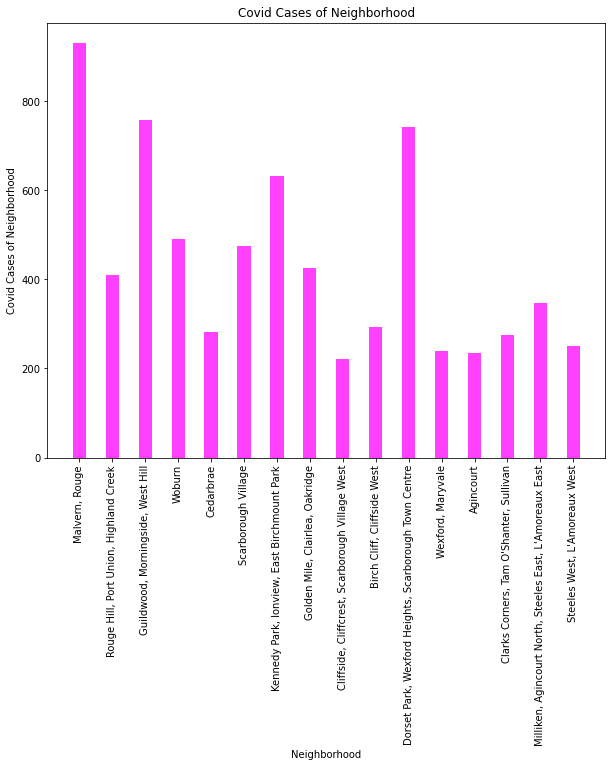

In [315]:
### Load dataset

nei = list(dt_merged2.Neighborhood)

covid = list(dt_merged2.Count)


fig = plt.figure(figsize = (10,8))


### Creating bar plot

plt.bar(nei, covid, color = 'magenta', width = 0.4, alpha = .75)

plt.xlabel('Neighborhood')
plt.xticks(rotation = 90

plt.ylabel('Covid Cases of Neighborhood')
plt.title('Covid Cases of Neighborhood')
plt.show()




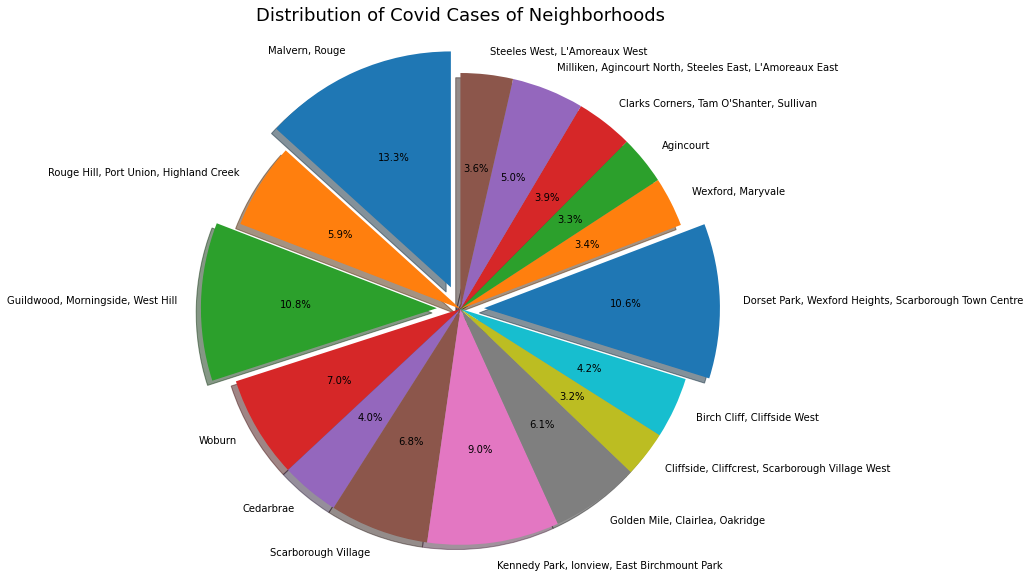

In [312]:
### Pie Chart

labels = dt_merged2.Neighborhood
sizes = dt_merged2.Count


### Only 'explode' the top 3 slides 

explode = (0.1,0,0.1,0,0,0,0,0,0,0,0.1,0,0,0,0,0)


### Plot

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels = labels, autopct = '%1.1f%%',
       shadow = True, startangle = 90)


### Equal aspect ratio ensures that pie is drawn as a circle

ax1.axis('equal')



### Adjust plot size 

fig1 = plt.gcf()
fig1.set_size_inches(10,10)

ax1.set_title('Distribution of Covid Cases of Neighborhoods', fontdict = {'fontsize': 18})
plt.show()



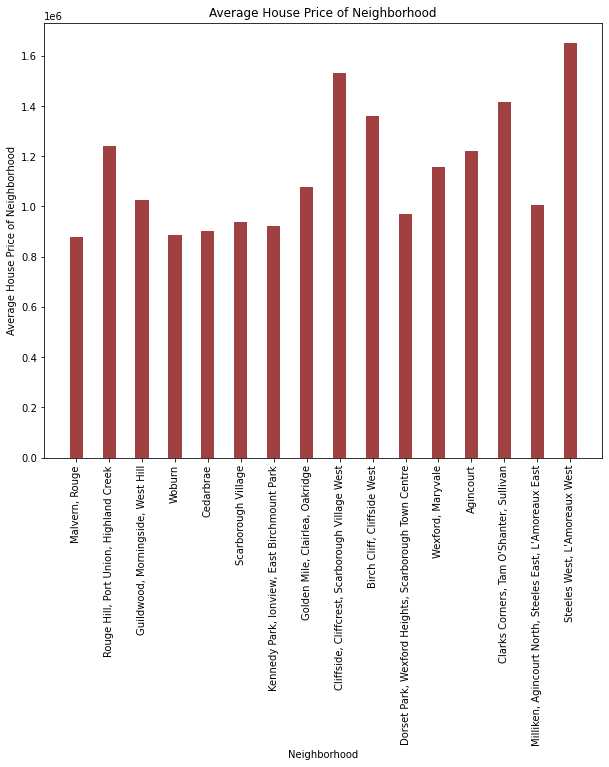

In [316]:
### Load dataset

nei = list(dt_merged2.Neighborhood)

ap = list(dt_merged2.AvgPrice)


fig = plt.figure(figsize = (10,8))


### Creating bar plot

plt.bar(nei, ap, color = 'maroon', width = 0.4, alpha = .75)

plt.xlabel('Neighborhood')
plt.xticks(rotation = 90)

plt.ylabel('Average House Price of Neighborhood')
plt.title('Average House Price of Neighborhood')
plt.show()

